<h1>Cats and Dogs Classification using Resnet50 pretrained model.</h1>

In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision

In [0]:
import torch
import torchvision
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.autograd import Variable
import pandas as pd
import PIL
import os, sys, time
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [0]:
plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

In [0]:
from google.colab import files
files = files.upload()

Saving valid.zip to valid.zip


In [0]:
import io
import zipfile
zip_ref = zipfile.ZipFile("train.zip","r")
zip_ref.extractall()
zip_ref.close()


In [0]:
import io
import zipfile
zip_ref = zipfile.ZipFile("valid.zip","r")
zip_ref.extractall()
zip_ref.close()

In [0]:
!ls

layer_op  sample_data  train  train.zip  valid	valid.zip


In [0]:
!pwd

/content


In [0]:

train="/content/train"
test="/content/valid"

In [0]:
class Cat_Dog(Dataset):
  def __init__(self, root_dir, transform=None):
    self.root_dir = root_dir
    self.files = os.listdir(root_dir)
    self.img_lab={}
    for f in self.files:
      label = f.split('.')[0]
      self.img_lab[f] = label
    files = pd.Series(self.img_lab)
    self.labels,_ = files.factorize()
    self.transform = transform
  def __len__(self):
    return len(self.files)
  def __getitem__(self, idx):
    img = self.files[idx]
    label = self.labels[idx]
    image = PIL.Image.open(os.path.join(self.root_dir, img))
    if self.transform:
      image=self.transform(image)
    return image, label

In [0]:
train_data = Cat_Dog(train, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()]))
test_data = Cat_Dog(test, transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), torchvision.transforms.ToTensor()]))

In [0]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)
data_loader ={'train':train_loader,'test':test_loader} 


 0
 1
 1
 1
 0
 0
 0
 0
 0
 0
[torch.LongTensor of size 10]

torch.Size([3, 224, 224])


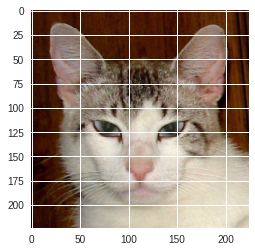

In [0]:
img, label = next(iter(test_loader))
plt.imshow(img[0].permute(1,2,0))
print(label)
no_classes = 2
print(img[0].shape)

In [0]:
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_loader))
if use_gpu:
    resnet = resnet.cuda()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())   
else:
    inputs, labels = Variable(inputs), Variable(labels)
outputs = resnet(inputs)
print(outputs.size())
print(resnet)

torch.Size([10, 1000])
ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)

In [0]:
def train_model(data_loader, resnet, criterion, optimizer, num_epochs=2):
    since = time.time()
    use_gpu = torch.cuda.is_available()
    best_model_wts = resnet.state_dict()
    best_acc = 0.0
    dataset_sizes = {'train': len(data_loader['train']), 
                     'test': len(data_loader['test'])}

    for epoch in range(num_epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                print("training....")
                resnet.train(True)
            else:
                resnet.train(False)

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader[phase]:
                if use_gpu:
                    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = resnet(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                train_epoch_loss = running_loss / dataset_sizes[phase]
                train_epoch_acc = running_corrects / dataset_sizes[phase]
            else:
                valid_epoch_loss = running_loss / dataset_sizes[phase]
                valid_epoch_acc = running_corrects / dataset_sizes[phase]
                
            if phase == 'valid' and valid_epoch_acc > best_acc:
                best_acc = valid_epoch_acc
                best_model_wts = model.state_dict()

        print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f} ' 
              'valid loss: {:.4f} acc: {:.4f}'.format(
                epoch, num_epochs - 1,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc))

    resnet.load_state_dict(best_model_wts)
    return resnet

In [0]:
# freezin the all layers
for param in resnet.parameters():
  param.require_grad = True
  
#new final layer with 2 classes
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 2)
if use_gpu:
    resnet = resnet.cuda()
print(resnet)

ResNet(
  (conv1): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d (64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (conv3): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d (64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (1):

In [0]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.fc.parameters(), lr=0.001, momentum=0.9)

In [0]:
start_time = time.time()
resnet = train_model(data_loader, resnet, criterion, optimizer, num_epochs=2)
print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

training....
Epoch [0/1] train loss: 0.7589 acc: 5.1304 valid loss: 1.1028 acc: 4.3636
training....
Epoch [1/1] train loss: 0.7382 acc: 5.3261 valid loss: 0.6705 acc: 5.5455
Best val Acc: 0.000000
Training time:  13.602763 minutes


In [0]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [0]:
def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[classes[x] for x in classes])

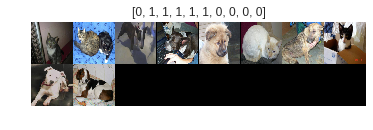

In [0]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
show_databatch(inputs, classes)